In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
np.random.seed(1234)
%matplotlib inline

In [9]:
STAGE1_TRAIN = "/media/hdd10tb/zchen/dsb2018/data/stage1_train"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"

In [10]:
def image_ids_in(root_dir, ignore=[]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids

In [11]:
def read_image(image_id, space="rgb"):
    image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    image = image[:, :, :3]
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

In [12]:
# Get image width, height and count masks available.
def read_image_labels(image_id, space="rgb"):
    image = read_image(image_id, space = space)
    mask_file = STAGE1_TRAIN_MASK_PATTERN.format(image_id)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = 255 #index + 1
    return image, labels, num_masks

In [13]:
# Load stage 1 image identifiers.
train_image_ids = image_ids_in(STAGE1_TRAIN)

In [20]:
train_image_ids

['a5fe0b7412dd152c41f7afc34ffdf276d4261b6942fa6d36803648e90f2cfc06',
 'f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7bf009a013847608da27',
 'bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96',
 '5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653890636eef88a944e14',
 '5afcbfd0dd64392aa1e233b996d0bfb4354ee7119f30ae111c33d0fe4df11590',
 'b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac',
 '75120baa6abcbfe750a4eb223b8c10ae6bc3bebdda7b00d9a78bc2472fa28625',
 'cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490',
 'f4faa3a409014db1865074c5f66a0255f71ae3faba03265da0b3b91f68e8a8f0',
 '1f0008060150b5b93084ae2e4dabd160ab80a95ce8071a321b80ec4e33b58aca',
 'f9ac03b0344ce8c48bc058448541f9211a1e5f4c94fdaf633dd534328d8610ab',
 'ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb',
 'a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606',
 'b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39ff843884d84f61dee1',
 '8bef203fce625e4d8c89dca728158be4

In [21]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

In [22]:
def get_images_details(image_ids):
    details = []
    for image_id in image_ids:
        image_hsv, labels, num_masks = read_image_labels(image_id, space="hsv")
        height, width, l = image_hsv.shape
        dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=1)
        dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        info = (image_id, width, height, num_masks, dominant_colors_hsv.squeeze())
        details.append(info)
    return details

In [23]:
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT, TOTAL_MASK]
COLS = META_COLS + [HSV_DOMINANT]

In [31]:
'.DS_Store' in train_image_ids

False

In [30]:
train_image_ids.remove('.DS_Store')

In [32]:
details = get_images_details(train_image_ids)

In [33]:
trainPD = pd.DataFrame(details, columns=COLS)
X = (pd.DataFrame(trainPD[HSV_DOMINANT].values.tolist())).as_matrix()
kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.predict(X)
trainPD[HSV_CLUSTER] = clusters

In [34]:
trainPD.head()

,image_id,width,height,total_masks,hsv_dominant,hsv_cluster
0,a5fe0b7412dd152c41f7afc34ffdf276d4261b6942fa6d...,320,256,30,"[0.7368952597878229, 0.4148490975686071, 0.764...",1
1,f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7b...,256,256,30,"[0.0, 0.0, 0.04113075405943612]",0
2,bff985591dd5d6303018a6e9a3dcfb336771a414ad4605...,256,256,17,"[0.0, 0.0, 0.06730227002910306]",0
3,5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653...,256,256,15,"[0.0, 0.0, 0.023316506778493062]",0
4,5afcbfd0dd64392aa1e233b996d0bfb4354ee7119f30ae...,360,360,27,"[0.0, 0.0, 0.051867132655532354]",0


In [35]:
def plot_images(images, images_rows, images_cols):
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            image_id = images[row*images_cols + col]
            image = read_image(image_id)
            height, width, l = image.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(image)

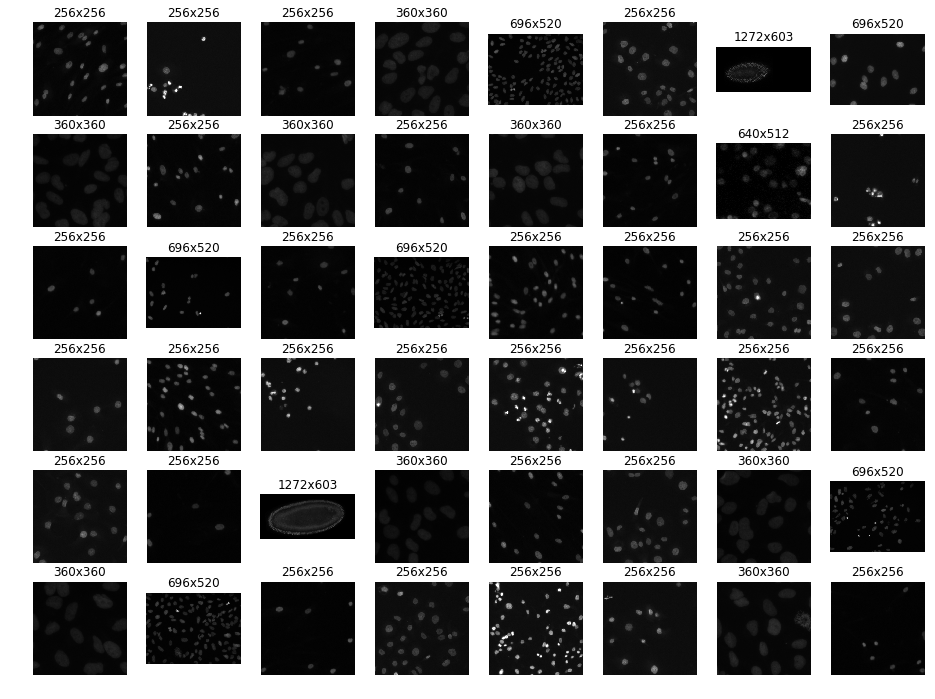

In [36]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 6, 8)

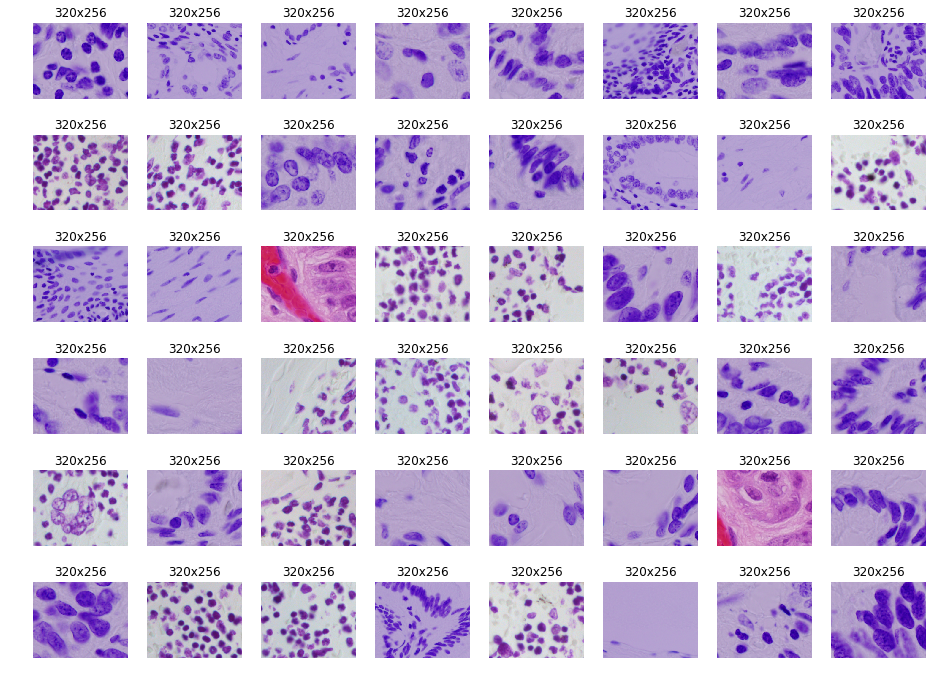

In [37]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 6, 8)

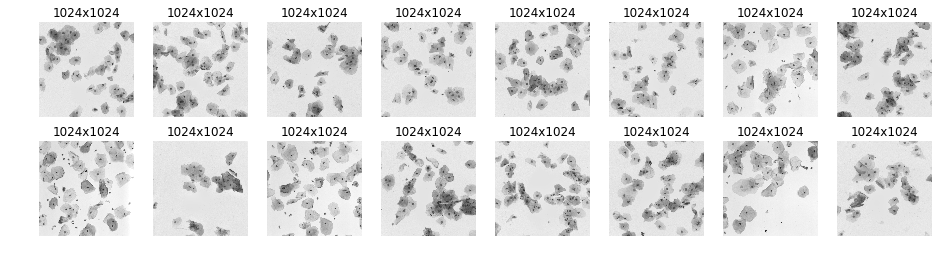

In [38]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 2, 8)

In [39]:
type(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID])

pandas.core.series.Series

In [ ]:
with open('/media/hdd10tb/zchen/dsb2018/data/split/'+train_name, 'w') as fp:
    fp.write('\n'.join(train_ids_603))